In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from matplotlib import pyplot as plt 
import glob
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib import colors, cm

## Make heatmaps of log likelihoods

In [2]:
#get viridis colormaps
def cmap_codes(name, number):
    cmap = cm.get_cmap(name, number) 
    hexcodes = []
    for i in range(cmap.N): 
        hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    return hexcodes

cmap_codes('viridis', 4)

['#440154', '#31688e', '#35b779', '#fde725']

Text(0.5, 1, 'fennoscandia 12000 - 1500 yrs \n GLAC-1D : 96 km lithosphere')

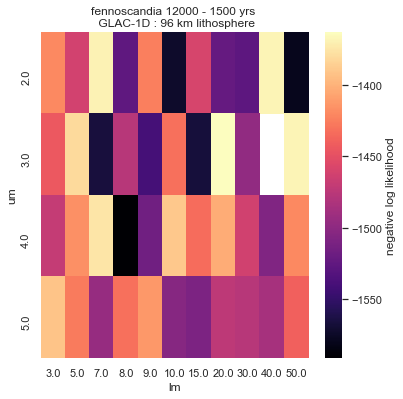

In [117]:
tmax = 12000
tmin = 1500
model = 'GLAC-1D'
mantle = 'l96C'
lith = '96'
place = 'fennoscandia'
dirName = f'figs/{place}/'
path_gen = f'{tmax}_{tmin}_{model}_{mantle}_{place}'

all_files = glob.glob(f'output/12000*glac1d_*{place}*likelihood')
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files)) 

df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]

df.lm = df.lm.astype(float)
df.um = df.um.astype(float)

heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(heatmap,  cmap='magma', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
ax.set_title('label')

ax.set_title(f'{place} {tmax} - {tmin} yrs \n {model} : {96} km lithosphere')
# fig.savefig(dirName + f'{path_gen}_likelihood_heatmap', transparent=True)


In [7]:
df_96 = df[df.lith == 'l96C']

df_96_um2 = df_96[df_96.um == 2.0]
df_96_um3 = df_96[df_96.um == 3.0]
df_96_um4 = df_96[df_96.um == 4.0]
df_96_um5 = df_96[df_96.um == 5.0]

df_71 = df[df.lith == 'l71C']





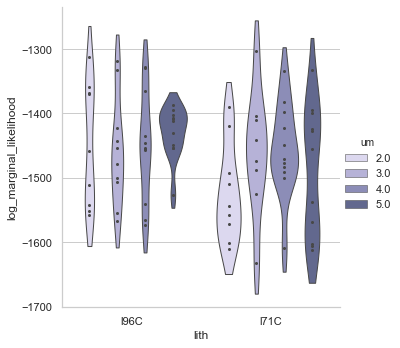

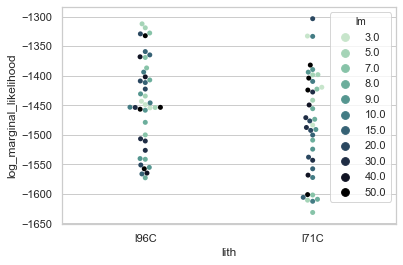

In [118]:
sns.set(style="whitegrid")

pal = sns.cubehelix_palette(4, start=2.8, rot=.1, dark=0.4)

# sns.swarmplot(x='lith', y="log_marginal_likelihood", hue='lm', data=df, palette='magma')
# sns.violinplot(x='lith', y="log_marginal_likelihood", data=df, hue='um', inner=None)
sns.catplot(x='lith', y="log_marginal_likelihood", data=df, hue='um', kind='violin', bw=0.5, cut=1, linewidth=1, inner='points', palette=pal)
# sns.catplot(x='lith', y="log_marginal_likelihood", data=df[df.ice_model == 'glac1d'], kind='violin', split=True, palette={"UM": "um", "No": "lm"})


plt.show()
pal = sns.cubehelix_palette(11, rot=-.4, dark=0)
sns.swarmplot(x='lith', y="log_marginal_likelihood", data=df, hue='lm', palette=pal)


In [8]:
fig, ax = plt.subplots(1, 1, 1, figsize=(10,6))

ax.plot(df_96)

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: sharex argument to subplots() was an integer.  Did you intend to use subplot() (without 's')?
  """Entry point for launching an IPython kernel.


ValueError: 1 is not a valid value for sharex; supported values are 'all', 'row', 'col', 'none'

<Figure size 720x432 with 0 Axes>

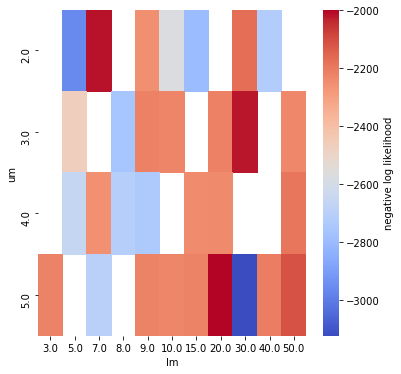

In [166]:
tmax = 12000
tmin = 1500

all_files = glob.glob(f'output/12000*d6g_h6g*atlantic*likelihood')
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files)) 

df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]

df.lm = df.lm.astype(float)
df.um = df.um.astype(float)

heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(heatmap,  cmap='coolwarm', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
# ax.set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model} : {df_likes.lith[0]} km lithosphere');

In [127]:
# df.set_index(df.modelrun).drop(columns='modelrun').reset_index()

,modelrun,log_marginal_likelihood
0,glac1d_l96C_ump5_lm3,-1449.107052
1,glac1d_l71C_ump3_lm50,-1404.184751
2,glac1d_l96C_ump5_lm30,-1526.428024
3,glac1d_l96C_ump3_lm3,-1443.372125
4,glac1d_l71C_ump5_lm7,-1602.031703
...,...,...
77,glac1d_l96C_ump2_lm20,-1551.295864
78,glac1d_l71C_ump4_lm8,-1609.297943
79,glac1d_l96C_ump2_lm15,-1359.264722
80,glac1d_l71C_ump2_lm8,-1509.182020


## Make datasets with gp regression model output

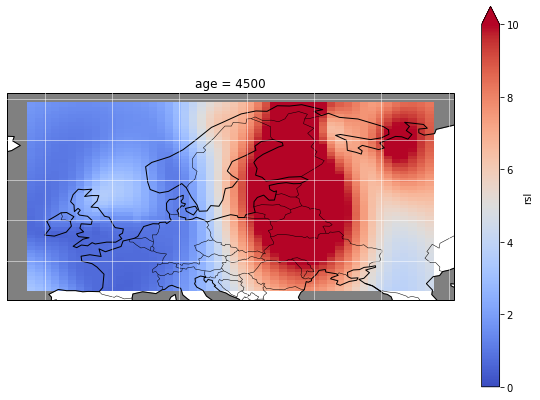

In [96]:
locs = {
                'england': [-12, 2, 50, 60],
                'easternhem': [50, 178, -45, 80],
                'westernhem': [-175, 30, -80, 75],
                'world': [-179.8, 179.8, -89.8, 89.8],
                'namerica': [-150, -20, 10, 75],
                'eastcoast': [-88, -65, 15, 40],
                'europe': [-20, 15, 35, 70],
                'atlantic':[-85,50, 25, 73],
                'fennoscandia': [-15, 50, 45, 73],
            }

def download_files(varname):


#  varname = 'variance'
    globvar = glob.glob(f'output/12000*fennoscandia*{varname}')

    place = [val.split('_gia')[0].split('_') for val in globvar]
    places = []
    for i, it in enumerate(place):
        [places.append(loc) for loc in it if loc in locs] 

    ds = xr.open_mfdataset(globvar, concat_dim='modelrun', combine='nested')
    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
    except:
        pass

    return ds

names = ['giaprior', 'gp_variance', 'da_zp', 'posterior']

ds_giaprior, ds_var, ds_zp, ds_post  = [download_files(it) for it in names]



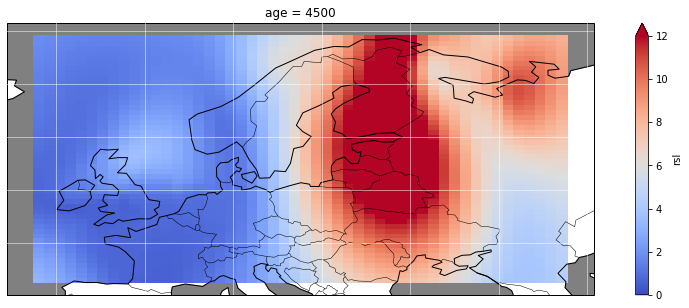

In [100]:
fig = plt.figure(figsize=(15, 5)) 
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines(resolution='110m', linewidth=1, zorder=2)
ax.add_feature(cfeature.OCEAN, color='gray', zorder=0)
# ax.add_feature(cfeature.LAND, color='palegreen', zorder=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

ds_zp.rsl.std(dim='modelrun').sel(age=4500).plot(ax=ax, vmin=0, vmax=12, cmap='coolwarm');

In [5]:
def download_files(varname):
    
    globvar = glob.glob(f'output/12000*{varname}')
    lith = ["_".join(val.split('um')[0].split('_')[-2:][:-1]) for val in globvar]
    place = [val.split('_gia')[0].split('_') for val in globvar]
    places = []
    for i, it in enumerate(place):
        [places.append(loc) for loc in it if loc in locs] 
    
    mantle = ["_".join(val.split('C_')[1].split('_')[:2]) for val in globvar]
    model = ["_".join(val.split('_l')[0].split('_')[2:]) for val in globvar]
    ds = xr.open_mfdataset(globvar, concat_dim='mantle', combine='nested')
    ds['mantle'] = mantle

    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
        ds = ds.drop('scale')
#         ds = ds.drop('modelrun')
    except:
        pass
    ds = ds.expand_dims({'lith':lith, 'place':places, 'model':model})
    return ds
names = ['giaprior', 'gp_variance', 'da_zp', 'posterior']
ds_giaprior, ds_var, ds_zp, ds_post  = [download_files(it) for it in names]

In [6]:
ds_var

<xarray.Dataset>
Dimensions:  (age: 106, lat: 50, lith: 81, lon: 50, mantle: 81, model: 81, place: 81)
Coordinates:
  * lith     (lith) <U4 'l71C' 'l96C' 'l71C' 'l96C' ... 'l96C' 'l71C' 'l71C'
  * place    (place) <U12 'fennoscandia' 'fennoscandia' ... 'fennoscandia'
  * model    (model) <U7 'glac1d' 'glac1d' 'glac1d' ... 'd6g_h6g' 'glac1d'
  * age      (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * lon      (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 43.49 44.7 45.9 47.11
  * lat      (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * mantle   (mantle) <U9 'ump2_lm50' 'ump3_lm5' ... 'ump3_lm3' 'ump4_lm10'
Data variables:
    rsl      (lith, place, model, mantle, age, lat, lon) float64 dask.array<chunksize=(81, 81, 81, 1, 106, 50, 50), meta=np.ndarray>

In [22]:
test = ds_post.rsl.sel(model='d6g_h6g', place='fennoscandia', lith='l96C').mean(dim=['model', 'place', 'lith']).std(dim=['mantle'])[100]
test = client.persist(test)
test.dask

AttributeError: 'DataArray' object has no attribute 'dask'

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [18]:
cluster.scale(4)

In [19]:
client

Client Scheduler: tcp://127.0.0.1:51838 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [364]:
ds_post.sel(model='d6g_h6g').mean(dim='modelrun').plot()



KeyError: 10

In [245]:
globvar = glob.glob(f'output/12000*likelihood')
globvar


['output/12000_1500_d6g_h6g_l71C_ump5_lm15_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump4_lm8_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump5_lm15_atlantic_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump3_lm30_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump4_lm10_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump3_lm9_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump2_lm30_atlantic_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump4_lm3_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump3_lm9_atlantic_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump2_lm3_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump2_lm5_atlantic_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump5_lm20_atlantic_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump4_lm40_fennoscandia_loglikelihood',
 'output/12000_1500_d6g_h6g_l71C_ump4_lm15_atlantic_loglikelihood',
 'output/12000_1500_d6

In [196]:
ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior

<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103)
Coordinates:
    scale     (age) float64 dask.array<chunksize=(119,), meta=np.ndarray>
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) object 'glac1d_l71C_ump5_lm20' ... 'd6g_h6g_l96C_ump5_lm10'
Data variables:
    rsl       (modelrun, lat, lon, age) float64 dask.array<chunksize=(1, 50, 50, 119), meta=np.ndarray>

In [241]:
places = [val.split('_gia')[0].split('_') for val in gprior][0]
places

['output/12000', '2000', 'glac1d', 'l71C', 'ump5', 'lm20', 'fennoscandia']

In [243]:
var[0]

'output/12000_2000_d6g_h6g_l71C_ump5_lm50_fennoscandia_gp_variance'

In [242]:
places = [val.split('_gia')[0].split('_') for val in var][0]
places

['output/12000',
 '2000',
 'd6g',
 'h6g',
 'l71C',
 'ump5',
 'lm50',
 'fennoscandia',
 'gp',
 'variance']

In [282]:
places = [val.split('_gia')[0].split('_') for val in var]


# print(places[4])
number = 2
if "fennoscandia" in places[number]:
    print('in')
elif "atlantic" in places[number]:
    print('out')
# try:
# except:
#     [s for s in places[number] if "atlantic" in s]


out


[]

In [259]:
places = [val.split('_gia')[0].split('_') for val in var]
try:
    [s for s in places[0] if "fennoscandia" in s]
    [s for s in places[0] if "atlantic" in s]
except:
    pass
# places[0]

In [246]:
def clean(ds, modelrun, runs):
    ds = ds.rename({'__xarray_dataarray_variable__':'var'})
    ds = ds.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
    return ds


 
gprior = glob_ds('giaprior')
var = glob_ds('variance')
zp = glob_ds('zp')
post = glob_ds('posterior')


runs = [val.split('/')[1].split('_l')[0] for val in gprior]
places = [val.split('_gia')[0].split('_')[-1] for val in gprior][0]
modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in gprior]

ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior = ds_giaprior.assign_coords({'run':runs, 'place':places}).drop('scale')



runs = [val.split('/')[1].split('_l')[0] for val in var]
places = [val.split('_gia')[0].split('_')[-1] for val in var][0]

modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in var]
ds_var = xr.open_mfdataset(var, concat_dim='modelrun', combine='nested')
ds_var = clean(ds_var, modelrun, runs)
ds_var

# runs = [val.split('/')[1].split('_l')[0] for val in zp]
# modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in zp]
# ds_zp = xr.open_mfdataset(zp, concat_dim='modelrun', combine='nested')
# ds_zp = clean(ds_zp, modelrun, runs)
# ds_zp


# ds_var = ds_var.rename({'__xarray_dataarray_variable__':'var'})
# ds_var = ds_var.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
# ds_var

<xarray.Dataset>
Dimensions:   (age: 106, lat: 99, lon: 99, modelrun: 63, run: 63)
Coordinates:
  * lon       (lon) float64 -86.48 -83.75 -81.03 -78.3 ... 44.38 44.7 45.9 47.11
  * lat       (lat) float64 23.51 24.48 25.46 26.43 ... 70.11 70.26 70.67 71.23
  * age       (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * modelrun  (modelrun) <U43 'd6g_h6g_l71C_ump2_lm30' ... 'd6g_h6g_l71C_ump3_lm5_atlantic_gp_variance'
  * run       (run) <U18 '12000_1500_d6g_h6g' ... '12000_1500_d6g_h6g'
    place     <U8 'variance'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 106, 99, 99), meta=np.ndarray>

In [ ]:
ds_zp = ds_zp.rename({'__xarray_dataarray_variable__':'var'})
ds_zp

In [154]:
del runs


In [166]:
post_out = [val for val in post]
post_out

[['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l71C',
  'ump4',
  'lm15',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '2000',
  'd6g',
  'h6g',
  'l71C',
  'ump2',
  'lm10',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l96C',
  'ump3',
  'lm5',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l96C',
  'ump2',
  'lm9',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l71C',
  'ump3',
  'lm8',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'glac1d',
  'l71C',
  'ump2',
  'lm40',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l71C',
  'ump5',
  'lm7',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '2000',
  'glac1d',
  'l71C',
  'ump5',
  'lm20',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',
  'd6g',
  'h6g',
  'l71C',
  'ump2',
  'lm9',
  'fennoscandia',
  'posterior'],
 ['output/12000',
  '1500',

In [156]:
ds_post = xr.open_mfdataset(post, concat_dim='modelrun', combine='nested')
ds_post = clean(ds_post)

<xarray.Dataset>
Dimensions:                        (age: 119, lat: 50, lon: 50, modelrun: 103)
Coordinates:
    scale                          (age) float64 dask.array<chunksize=(119,), meta=np.ndarray>
  * lon                            (lon) float64 -11.95 -10.74 ... 45.9 47.11
  * lat                            (lat) float64 43.86 44.42 ... 70.67 71.23
  * age                            (age) int64 200 300 400 ... 11800 11900 12000
  * modelrun                       (modelrun) object 'd6g_h6g_l71C_ump4_lm15' ... 'd6g_h6g_l96C_ump5_lm10'
Data variables:
    __xarray_dataarray_variable__  (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 119, 50, 50), meta=np.ndarray>

In [ ]:
post = [val for val in post]

ds_post = xr.open_mfdataset(post, concat_dim='modelrun', combine='nested')
ds_post = clean(ds_post)


ds_post    

<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103, place: 103, run: 103)
Coordinates:
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) <U22 'd6g_h6g_l71C_ump4_lm40' ... 'd6g_h6g_l71C_ump4_lm3'
  * run       (run) <U18 '12000_2000_d6g_h6g' ... '12000_2000_d6g_h6g'
  * place     (place) <U12 'fennoscandia' 'fennoscandia' ... 'fennoscandia'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 119, 50, 50), meta=np.ndarray>

In [20]:
path = 'output/12000_1500_d6g_h6g_l71C_ump2_lm10_fennoscandia_da_zp'
ds = xr.open_mfdataset('')
ds

OSError: [Errno -51] NetCDF: Unknown file format: b'/Users/rogercreel/ws/Holocene_readv/output/12000_1500_d6g_h6g_l71C_ump2_lm10_fennoscandia_loglikelihood'

In [5]:
df = pd.DataFrame()
f = open('output/12000_1500_d6g_h6g_l71C_ump2_lm10_fennoscandia_da_zp', 'r')
for line in f:
    df = pd.concat([df, pd.read_json(line, orient='columns')])

ValueError: Expected object or value

In [16]:
df = pd.read_csv('output/12000_1500_d6g_h6g_l71C_ump2_lm10_fennoscandia_da_zp', encoding = "ISO-8859-1",)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 8, saw 4


In [9]:
with open(path, 'rb') as f:
  contents = f.read()
# for line in f:
#     df = pd.concat([df, pd.read_json(line, orient='columns')])

ValueError: I/O operation on closed file.